In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/pytorch_youtube/data

/content/drive/MyDrive/pytorch_youtube/data


In [4]:
!unzip -qq "/content/drive/MyDrive/pytorch_youtube/data/archive.zip"

In [5]:
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # Load img
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('/content/drive/MyDrive/pytorch_youtube/data/flickr8k/captions.txt')
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [6]:
# 텍스트를 수치값으로 변경하고자 할 경우 
# 1. 각 단어를 인덱스에 바로 매핑할 수 있도록 단어장이 필요
# 2. 데이터셋을 불러오기 위한 pytorch dataset을 설정
# 3. 모든 배치의 패딩값 설정 (시퀀스의 길이가 같도록)

spacy_eng = spacy.load("en_core_web_sm")


class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]
    # "I Love Peanuts" -> ["i", "love", "peanuts"]

    def build_vocabulary(self, sentence_list):
        frequencies = {} # 특정 단어가 반복되는 횟수 체크 
        idx = 4 # 위 단어장 때문에 인덱스는 4부터 시작

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text): 
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # 이미지와 caption 컬럼 받기
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # vocab 설정
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        
        # 이미지를 불러와 RGB값으로 변환
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]  # 문자열을 인덱스로 지정 + Start 토큰 추가 
        numericalized_caption += self.vocab.numericalize(caption) # 로드한 단어를 단어장 내의 값으로 변환
        numericalized_caption.append(self.vocab.stoi["<EOS>"]) # end 토큰 추가

        return img, torch.tensor(numericalized_caption)


class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets


def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=32,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset

In [7]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)), transforms.ToTensor(),]
)

loader, dataset = get_loader(
    "/content/drive/MyDrive/pytorch_youtube/data/flickr8k/images/", "/content/drive/MyDrive/pytorch_youtube/data/flickr8k/captions.txt", transform=transform
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


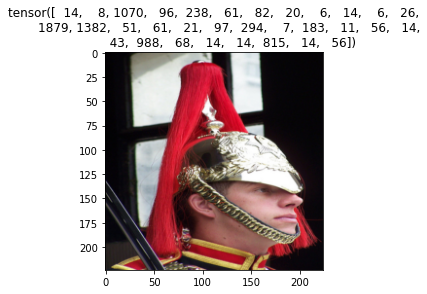

In [8]:
idx = 0
img_arr = []
caption_arr = []
for idx, (imgs, captions) in enumerate(loader):
    for idx in range(3):
        img_arr.append(imgs[idx])
        caption_arr.append(captions[idx])
            
        plt.title(caption_arr[idx])
        plt.imshow(img_arr[idx].permute(1,2,0))
            
        # break
    break